### Initialization cells

In [8]:
import sys, os
# print(os.getcwd())
# sys.path.append("./Python/tests")
# print(sys.path)
from conformer_generator import *
from utility_functions import *

In [22]:
# files from IQMol
scratch_path, scratch_dirs, scratch_files = os.walk("/Users/exequielpunzalan/Desktop/iqmol_scratch").__next__()
print(scratch_path, scratch_dirs, scratch_files)
input_file = scratch_path+"/input/input.mol" # what the user starts working with
mol_files = [scratch_path+"/"+f for f in scratch_files if f[-4:] == '.mol'] # only get mol files
print(mol_files)
num_files = len(mol_files)
print(num_files)

/Users/exequielpunzalan/Desktop/iqmol_scratch ['input'] ['.DS_Store', '20190918_204039.mol', '20190918_204044.mol', '20190918_204058.mol']
['/Users/exequielpunzalan/Desktop/iqmol_scratch/20190918_204039.mol', '/Users/exequielpunzalan/Desktop/iqmol_scratch/20190918_204044.mol', '/Users/exequielpunzalan/Desktop/iqmol_scratch/20190918_204058.mol']
3


In [23]:
# .mol files --> 1 .sdf file
molfile_to_sdf(mol_files, outfile=scratch_path+"/conformers.sdf")
print(scratch_path + "/conformers.sdf")
# read in SDF to RDKit
mols_out = load_from_sdf(scratch_path + "/conformers.sdf")
print([mol.GetNumAtoms() for mol in mols_out])

/Users/exequielpunzalan/Desktop/iqmol_scratch/conformers.sdf
Loading SDF file...	3 conformers as Molecule type loaded
[20, 20, 20]


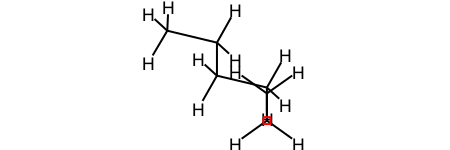

In [24]:
mols_out[0]

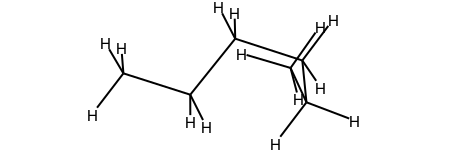

In [25]:
mols_out[1]

In [26]:
confgen = ConformerGeneratorCustom(max_conformers=num_files,
                                   rmsd_threshold=0,
                                   tfd_threshold=0,
                                   force_field='mmff',
                                   pool_multiplier=1)

In [27]:
# assuming all files are the same molecule,
# consolidate all Molecules into 1 RDKit Molecule such that they become RDKit Conformers

input_file = [scratch_path+"/input/input.mol"]
input_mol_sdf = molfile_to_sdf(input_file, outfile=scratch_path+"/input/input.sdf")
input_mol = load_from_sdf(scratch_path + "/input/input.sdf")[0]
input_mol.RemoveAllConformers() # remove input Conformer object
mol = confgen.add_conformers_as_Molecules_to_Molecule(input_mol, confs=mols_out)


Loading SDF file...	Molecule loaded.


In [28]:
print(mol.GetNumConformers())
print([c.GetId() for c in mol.GetConformers()])

3
[0, 1, 2]


### No pruning

In [38]:
rmsd = ConformerGeneratorCustom.get_conformer_rmsd_fast(mol)
pruned_mol_rmsd, pruned_rmsd = confgen.prune_conformers(mol, rmsd, measure="rmsd")
print([c.GetId() for c in pruned_mol_rmsd.GetConformers()])

Calculating RMSDs of conformer 2: 100%|██████████| 3/3 [00:00<00:00, 266.15it/s]

Pruning conformers...
Computing RMSD matrix of pruned conformers...
Done.
[1, 0, 2]


In [39]:
tfd = ConformerGeneratorCustom.get_tfd_matrix(mol)
unpruned_mol_tfd, unpruned_tfd = confgen.prune_conformers(mol, tfd, measure="tfd")
print([c.GetId() for c in pruned_mol_rmsd.GetConformers()])

Pruning conformers...
Computing TFD array of pruned conformers...
Done
[1, 0, 2]


In [40]:
rmsd

array([[0.        , 1.46970457, 1.70977361],
       [1.46970457, 0.        , 1.49488392],
       [1.70977361, 1.49488392, 0.        ]])

In [41]:
tfd

array([[0.        , 0.43346675, 0.61053339],
       [0.43346675, 0.        , 0.21577952],
       [0.61053339, 0.21577952, 0.        ]])

### 1A RMSD, 0.2 TFD cutoffs

In [42]:
confgen = ConformerGeneratorCustom(max_conformers=num_files,
                                   rmsd_threshold=1,
                                   tfd_threshold=0.2,
                                   force_field='mmff',
                                   pool_multiplier=1)

In [43]:
rmsd = ConformerGeneratorCustom.get_conformer_rmsd_fast(mol)
pruned_mol_rmsd, pruned_rmsd = confgen.prune_conformers(mol, rmsd, measure="rmsd")

tfd = ConformerGeneratorCustom.get_tfd_matrix(mol)
pruned_mol_tfd, pruned_tfd = confgen.prune_conformers(mol, tfd, measure="tfd")

Calculating RMSDs of conformer 2: 100%|██████████| 3/3 [00:00<00:00, 747.16it/s]

Pruning conformers...
Computing RMSD matrix of pruned conformers...
Done.
Pruning conformers...
Computing TFD array of pruned conformers...
Done


In [44]:
print([c.GetId() for c in pruned_mol_rmsd.GetConformers()])
pruned_rmsd

[1, 0, 2]


array([[0.        , 1.46970457, 1.49488392],
       [1.46970457, 0.        , 1.70977361],
       [1.49488392, 1.70977361, 0.        ]])

In [45]:
print([c.GetId() for c in pruned_mol_tfd.GetConformers()])
pruned_tfd

[1, 0, 2]


array([[0.        , 0.43346675, 0.21577952],
       [0.43346675, 0.        , 0.61053339],
       [0.21577952, 0.61053339, 0.        ]])

### Partition function

In [46]:
energies_rmsd = confgen.get_conformer_energies(pruned_mol_rmsd)
energies_tfd = confgen.get_conformer_energies(pruned_mol_tfd)
print(energies_rmsd)
print(energies_tfd)

[-2.1983365  -1.67664528 54.72298005]
[-2.1983365  -1.67664528 54.72298005]


In [47]:
pf_rmsd = np.sum(np.exp(-energies_rmsd/0.593))
pf_tfd = np.sum(np.exp(-energies_tfd/0.593)) # RT = 0.593 kcal/mol
print(pf_rmsd)
print(pf_tfd)

57.638678842672675
57.63867884267292


In [48]:
prob_confs_rmsd = [np.exp(-e/0.593)/pf_rmsd for e in energies_rmsd]
prob_confs_tfd = [np.exp(-e/0.593)/pf_tfd for e in energies_tfd]
print(prob_confs_rmsd)
print(prob_confs_tfd)

[0.7067702266686569, 0.2932297733313432, 1.4517864191236267e-42]
[0.7067702266686539, 0.2932297733313461, 1.4517864191236206e-42]


In [49]:
# free energy
kT = 4.11e-21/1000 # kJ
F_rmsd = -kT * np.log(pf_rmsd)
F_tfd = -kT * np.log(pf_tfd)
print(F_rmsd) # kJ
print(F_tfd)

-1.6662736723609865e-23
-1.6662736723609882e-23


### Saving

In [50]:
import pickle

mols_save_dir = scratch_path + "/rdkit_mols/"
os.makedirs(mols_save_dir, exist_ok=True)

In [51]:
# unpruned Molecule
with open(mols_save_dir + "unpruned_mol_rmsd.pkl", 'wb') as pickle_file:
    pickle.dump(unpruned_mol_rmsd, pickle_file)
with open(mols_save_dir + "unpruned_mol_tfd.pkl", 'wb') as pickle_file:
    pickle.dump(unpruned_mol_tfd, pickle_file)

# pruned Molecule
with open(mols_save_dir + "pruned_mol_{}rmsd.pkl".format(confgen.rmsd_threshold), 'wb') as pickle_file:
    pickle.dump(pruned_mol_rmsd, pickle_file)
with open(mols_save_dir + "pruned_mol_{}tfd.pkl".format(confgen.tfd_threshold), 'wb') as pickle_file:
    pickle.dump(pruned_mol_tfd, pickle_file)